In [1]:
from collections import namedtuple
import math
class P2(namedtuple('P2', ['u', 'v'])):
    __slots__ = ()
    def __new__(self, u, v):
        return super(P2, self).__new__(self, float(u), float(v))
    def __repr__(self):
        return "P2(%s, %s)" % (self.u, self.v)
    def __add__(self, a):
        return P2(self.u + a.u, self.v + a.v)
    def __sub__(self, a):
        return P2(self.u - a.u, self.v - a.v)
    def __mul__(self, a):
        return P2(self.u*a, self.v*a)
    def __neg__(self):
        return P2(-self.u, -self.v)
    def __rmul__(self, a):
        raise TypeError
    def Lensq(self):
        return self.u*self.u + self.v*self.v
    def Len(self):
        if self.u == 0.0:  return abs(self.v)
        if self.v == 0.0:  return abs(self.u)
        return math.sqrt(self.u*self.u + self.v*self.v)
    def LenLZ(self):
        return math.sqrt(self.x*self.x + self.y*self.y)
    def Arg(self):
        return math.degrees(math.atan2(self.v, self.u))
        
        
    def assertlen1(self):
        assert abs(self.Len() - 1.0) < 0.0001
        return True
        
    @staticmethod
    def Dot(a, b):
        return a.u*b.u + a.v*b.v
    @staticmethod
    def DotLZ(a, b):
        return a.u*b.x + a.v*b.y

    @staticmethod
    def ZNorm(v):
        ln = v.Len()
        if ln == 0.0:  
            ln = 1.0
        return P2(v.u/ln, v.v/ln)
            
    @staticmethod
    def APerp(v):
        return P2(-v.v, v.u)
    @staticmethod
    def CPerp(v):
        return P2(v.v, -v.u)

    @staticmethod
    def ConvertLZ(p):  
        return P2(p.x, p.y)


class P3(namedtuple('P3', ['x', 'y', 'z'])):
    __slots__ = ()
    def __new__(self, x, y, z):
        return super(P3, self).__new__(self, float(x), float(y), float(z))
    def __repr__(self):
        return "P3(%s, %s, %s)" % (self.x, self.y, self.z)
    def __add__(self, a):
        return P3(self.x + a.x, self.y + a.y, self.z + a.z)
    def __sub__(self, a):
        return P3(self.x - a.x, self.y - a.y, self.z - a.z)
    def __mul__(self, a):
        return P3(self.x*a, self.y*a, self.z*a)
    def __neg__(self):
        return P3(-self.x, -self.y, -self.z)
    def __rmul__(self, a):
        raise TypeError
    def Lensq(self):
        return self.x*self.x + self.y*self.y + self.z*self.z
    def Len(self):
        return math.sqrt(self.Lensq())
    def LenLZ(self):
        return math.sqrt(self.x*self.x + self.y*self.y)
        
        
    def assertlen1(self):
        assert abs(self.Len() - 1.0) < 0.0001
        return True
        
    @staticmethod
    def Dot(a, b):
        return a.x*b.x + a.y*b.y + a.z*b.z

    @staticmethod
    def Cross(a, b):
        return P3(a.y*b.z - b.y*a.z, -a.x*b.z + b.x*a.z, a.x*b.y - b.x*a.y)

    @staticmethod
    def Diff(a, b, bfore):
        if bfore:  return b - a
        return a - b
        
    @staticmethod
    def ZNorm(v):
        ln = v.Len()
        if ln == 0.0:  
            ln = 1.0
        return P3(v.x/ln, v.y/ln, v.z/ln)
            
    @staticmethod
    def ConvertGZ(p, z):  
        return P3(p.u, p.v, z)
    @staticmethod
    def ConvertCZ(p, z):  
        return P3(p.x, p.y, z)


In [2]:
import json
lnodes, paths = json.load(open("segmentedwing.txt"))
nodes = { }
for k, v in lnodes.items():
    v = eval(v)
    p = P2(max(0, min(1, v[0]/4)), max(0, min(1, v[1]/4)))
    nodes[k] = p
nodes["c4"] = P2(1,0)
cr0 = max((k  for k in nodes  if nodes[k][1] <= 0), key=lambda x:nodes[k][0])
cr1 = min((k  for k in nodes  if nodes[k][0] >= 1), key=lambda x:nodes[k][1])
paths.extend([cr0, "c4", "c4", cr1])

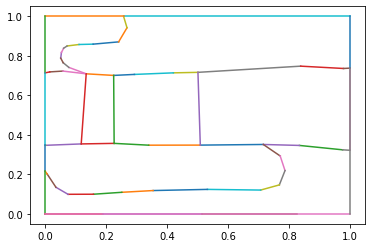

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
for i in range(0, len(paths), 2):
    p0, p1 = nodes[paths[i]], nodes[paths[i+1]]
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]])


In [4]:
wingmeshuvexpansionfac = 4.0
wingmeshuvudivisions = 19
wingmeshuvvdivisions = 67

import csv
r = csv.reader(open("Wing XYZ geometry.csv"))
k = list(r)
assert len(k) == 70


In [5]:
sections = [ ]
zvals = [ ]
for i in range(1, 60, 3):
    pts = [ ]
    z = float(k[2][i+1])
    for j in range(2, 70):
        assert (z == float(k[j][i+1]))
        pts.append(P2(float(k[j][i]), float(k[j][i+2])))
    zvals.append(z)
    sections.append(pts)
assert(len(sections) == wingmeshuvudivisions+1)


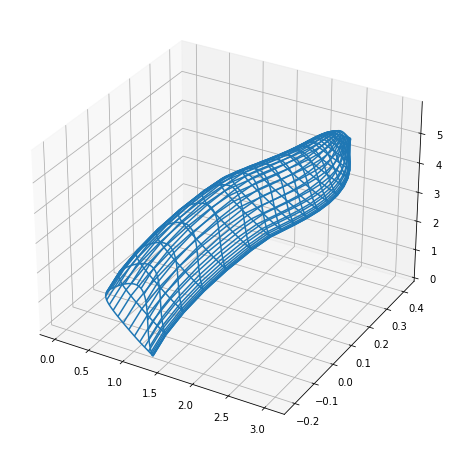

In [6]:
import numpy

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(projection='3d')
X = numpy.array([[p[0]  for p in pts]  for pts in sections])
Y = numpy.array([[p[1]  for p in pts]  for pts in sections])
Z = numpy.array([[z  for i in range(wingmeshuvvdivisions+1)]  for z in zvals])
ax.plot_wireframe(X, Y, Z)


In [7]:
import math, numpy

def convuv(uvx, uvy):
    usecl = uvx*wingmeshuvudivisions
    usec = int(max(0, min(wingmeshuvudivisions-1, math.floor(usecl))))
    ropepointlamda = usecl - usec
    aroundsegmentl = uvy*wingmeshuvvdivisions
    aroundsegment = int(max(0, min(wingmeshuvvdivisions-1, math.floor(aroundsegmentl))))
    lambdaCalong = aroundsegmentl - aroundsegment
    p00 = sections[usec][aroundsegment]
    p01 = sections[usec][aroundsegment+1]
    p10 = sections[usec+1][aroundsegment]
    p11 = sections[usec+1][aroundsegment+1]
    z = zvals[usec]*(1-ropepointlamda) + zvals[usec+1]*ropepointlamda
    p0 = p00*(1-ropepointlamda) + p10*ropepointlamda
    p1 = p01*(1-ropepointlamda) + p11*ropepointlamda
    p = p0*(1-lambdaCalong) + p1*lambdaCalong
    return P3(p[0], p[1], z)


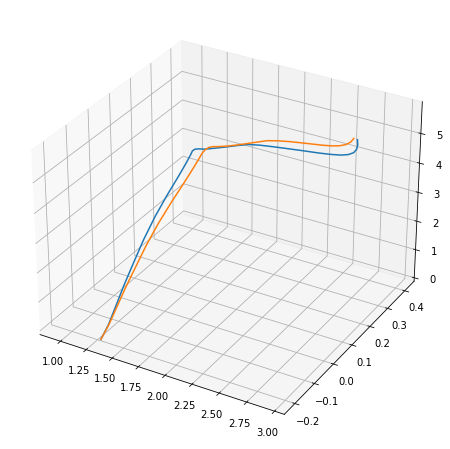

In [8]:

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(projection='3d')
u = numpy.linspace(0, 1, 31)
v = u
ps = [ convuv(uvx, uvy)  for uvx, uvy in zip(u, v) ]
ax.plot([p[0] for p in ps], [p[1] for p in ps], [p[2] for p in ps])
ps = [ convuv(uvx, uvy)  for uvx, uvy in zip(u, v*0.9) ]
ax.plot([p[0] for p in ps], [p[1] for p in ps], [p[2] for p in ps])


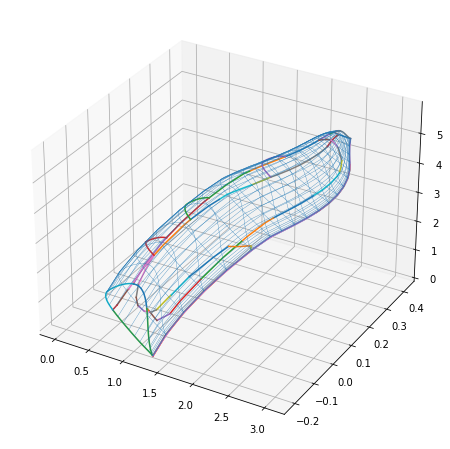

In [9]:

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(projection='3d')

for i in range(0, len(paths), 2):
    p0, p1 = nodes[paths[i]], nodes[paths[i+1]]
    ll = numpy.linspace(0, 1, 31)
    ps = [ convuv(p0[0]*(1-l) + p1[0]*l, p0[1]*(1-l) + p1[1]*l)  for l in ll ]
    ax.plot([p[0] for p in ps], [p[1] for p in ps], [p[2] for p in ps])
ax.plot_wireframe(X, Y, Z, linewidth=0.3)


In [10]:

def isinnerpoly(poly, nodepoints):
    jbl = 0
    ptbl = nodepoints[poly[jbl]]
    for j in range(1, len(poly)):
        pt = nodepoints[poly[j]]
        if pt.v < ptbl.v or (pt.v == ptbl.v and pt.u < ptbl.u):
            jbl = j
            ptbl = pt
    ptblFore = nodepoints[poly[(jbl+1)%len(poly)]]
    ptblBack = nodepoints[poly[(jbl+len(poly)-1)%len(poly)]]
    angFore = P2(ptblFore.u-ptbl.u, ptblFore.v-ptbl.v).Arg()
    angBack = P2(ptblBack.u-ptbl.u, ptblBack.v-ptbl.v).Arg()
    return (angBack < angFore)


nodepoints = nodes
onepathpairs = paths
Lpathvectorseq = { } 
for i in nodepoints.keys():
    Lpathvectorseq[i] = [ ]  # [ (arg, pathindex) ]
Npaths = int(len(onepathpairs)/2)
opvisits2 = [ ]
for i in range(Npaths):
    i0 = onepathpairs[i*2]
    i1 = onepathpairs[i*2+1]
    if i0 != i1:
        vec = nodepoints[i1] - nodepoints[i0]
        Lpathvectorseq[i0].append([vec.Arg(), i])
        Lpathvectorseq[i1].append([(-vec).Arg(), i])
        opvisits2.append(0)
        opvisits2.append(0)
    else:
        print("Suppressing loop edge in onepathpairs (how did it get here?) polynet function would fail as it relies on orientation")
        opvisits2.append(-1)
        opvisits2.append(-1)

    for pathvectorseq in Lpathvectorseq.values():
        pathvectorseq.sort()

polys = [ ]
linearpaths = [ ]
outerpoly = None
assert (len(opvisits2) == len(onepathpairs))
for i in range(len(opvisits2)):
    if opvisits2[i] != 0:
        continue
    ne = int(i/2)
    np = onepathpairs[ne*2 + (0 if ((i%2)==0) else 1)]
    poly = [ ]
    singlenodeindexes = [ ]
    hasnondoublenodes = False
    while (opvisits2[ne*2 + (0 if onepathpairs[ne*2] == np else 1)]) == 0:
        opvisits2[ne*2 + (0 if onepathpairs[ne*2] == np else 1)] = len(polys)+1
        poly.append(np)
        np = onepathpairs[ne*2 + (1  if onepathpairs[ne*2] == np  else 0)]
        if len(Lpathvectorseq[np]) == 1:
            singlenodeindexes.append(len(poly))
        elif len(Lpathvectorseq[np]) != 2:
            hasnondoublenodes = True
        for j in range(len(Lpathvectorseq[np])):
            if Lpathvectorseq[np][j][1] == ne:
                ne = Lpathvectorseq[np][(j+1)%len(Lpathvectorseq[np])][1]
                break

    # find and record the orientation of the polygon by looking at the bottom left
    if len(poly) == 0:
        print("bad poly size 0")
        continue

    if not isinnerpoly(poly, nodepoints):
        if outerpoly != None:
            print(" *** extra outer poly ", outerpoly, poly)
            polys.append(outerpoly) 
        outerpoly = poly
    else:
        polys.append(poly)


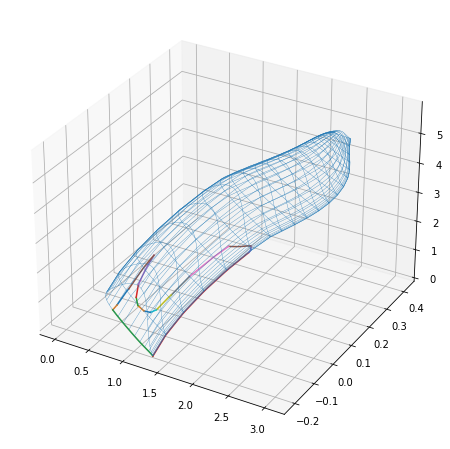

In [11]:

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(X, Y, Z, linewidth=0.3)

poly = polys[5]
for i in range(len(poly)):
    p0, p1 = nodes[poly[i]], nodes[poly[(i+1)%len(poly)]]
    ll = numpy.linspace(0, 1, 31)
    ps = [ convuv(p0[0]*(1-l) + p1[0]*l, p0[1]*(1-l) + p1[1]*l)  for l in ll ]
    ax.plot([p[0] for p in ps], [p[1] for p in ps], [p[2] for p in ps])


In [ ]:
#var dc = "run -it --rm -v %s:/data -v %s:/code pymesh/pymesh /code/polytriangulator.py /data/polygon.txt /data/mesh.txt %f %f" % \
#[ ProjectSettings.globalize_path("user://executingfeatures"), ProjectSettings.globalize_path("res://executingfeatures"), trilineleng, trilineshortleng ]
#print(dc)
#pymeshpid = OS.execute("docker", PoolStringArray(dc.split(" ")), false)
